# MOGPR S1 RVI and S2 L2A NDVI 

### Library import 

In [1]:
import openeo
from shapely.geometry import box
import pandas as pd
import numpy as np
from openeo.rest.conversions import timeseries_json_to_pandas
from datetime import datetime
from fusets.mogpr import mogpr_1D

### Data aquisition

The test site is from an agricultural area of Castilla and León(Spain). The labeled crop types are for the year 2019, subsets of 20x20 pixels

In [2]:
from IPython.display import display, Image
display(Image(url ='https://github.com/Open-EO/FuseTS/blob/main/notebooks/AI4FOOD_ITACYL_subsets.png?raw=true'))

Connect with VITO backend

In [3]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()

OIDC token response did not contain refresh token.


Authenticated using refresh token.


To retrieve AOI data from the year 2019, the spatiotemporal extent is determined as follows

In [4]:
spat_ext = {"west":-4.8909914254212605,"east":-4.820438599493526,"south":41.74687686378393,"north":41.79965426256652}
temp_ext = ["2015-11-20","2019-12-31"]

Extraction of RVI times series from Sentinel-1 (Ascending and Descending) and Sentinel-2 Level-2A NDVI.

In [5]:
from openeo.processes import eq
s1_desc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'DESCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )


VH = s1_desc.band("VH")
VV = s1_desc.band("VV")
rvi_desc_cube = (VH + VH) / (VV + VH)

s1_asc = connection.load_collection('SENTINEL1_GRD',
                                    spatial_extent = spat_ext,
                                    temporal_extent=temp_ext,
                                    bands=["VH","VV"],
                                    properties={
                                       "sat:orbit_state": lambda x: eq(x, 'ASCENDING'),
                                       "resolution": lambda x: eq(x, 'HIGH'),
                                       "sar:instrument_mode": lambda x: eq(x, 'IW')                                     
                                    }
                                   )
VH = s1_asc.band("VH")
VV = s1_asc.band("VV")
rvi_asc_cube = (VH + VH) / (VV + VH)

s2 = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                spatial_extent=spat_ext,
                                temporal_extent=temp_ext,
                                bands=["B04","B08","SCL"])
s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")
ndvi_cube = s2.ndvi(red="B04", nir="B08")

Subsets geometries

In [6]:
from shapely.geometry import box
subsets = {
    'Rye' : box(-4.867495201109149, 41.77850665915476, -4.865177772520282, 41.780106793555454),
    'Rape' : box(-4.875091217039325, 41.77290587433312, -4.872773788450457, 41.77450614847532),
    'Barley' : box(-4.879382751463153, 41.76996126559408,-4.8770653228742855, 41.77156161319915),
    'Wheat' : box(-4.851616523740985, 41.763015294346935, -4.8492990951521175, 41.76461581522523)    
}

Select one subset

In [7]:
crop = 'Wheat'
point_area = subsets[crop]

Get the timeseries of the subset

In [8]:
cubes_dfs = []
for cube in [ndvi_cube, rvi_desc_cube, rvi_asc_cube]:
    point_timeseries = cube.polygonal_mean_timeseries(point_area).execute()
    df = timeseries_json_to_pandas(point_timeseries)
    df.index = pd.to_datetime(df.index)
    cubes_dfs.append(df) 

# Join signal dfs
subset_df = pd.concat(cubes_dfs, axis=1)
subset_df = subset_df.rename(columns={0: 'NDVI', 1: 'RVI_DESC', 2: 'RVI_ASC'})  

Original timeseries of the subset

(0.0, 1.0)

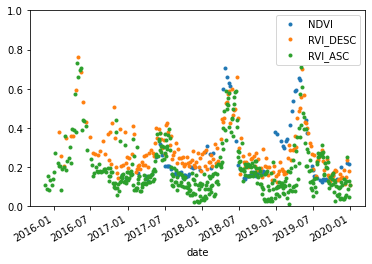

In [9]:
plot = subset_df.plot(marker='.', linestyle='None')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])

### MOGPR

Preprocessing for MOGPR

In [10]:
# Use only 2 signals
signals = ['NDVI', 'RVI_DESC']

time_step = 15
time       = []
data       = []
time_str   = []

for signal in signals:
    time_vec_num = np.asarray([ _.toordinal() for _ in subset_df.index], dtype=np.float64)        
    time.append(time_vec_num)
    data.append(subset_df[signal].to_numpy())         

time_vec_min        = np.min(list(pd.core.common.flatten(time)))
time_vec_max        = np.max(list(pd.core.common.flatten(time)))
output_timevec      = np.array(range(int(time_vec_min), int(time_vec_max), time_step), dtype = np.float64)  
output_time         = [datetime.fromordinal(int(_)) for _ in output_timevec]

Run MOGPR

In [11]:
master_ind = 1
nt = 1
out_mean, out_std, out_qflag, out_model = mogpr_1D(data[:], time[:],master_ind,output_timevec,nt)

Convert to pandas dataframe

In [12]:
nout = len(out_mean)
out_mean_list = []
for ind in range(nout):
    out_mean_list.append(out_mean[ind].ravel())
    
df_mogpr_out_mean = pd.DataFrame(np.column_stack(out_mean_list), columns=signals)
df_mogpr_out_mean.index = output_time

Plot the results

(0.0, 1.0)

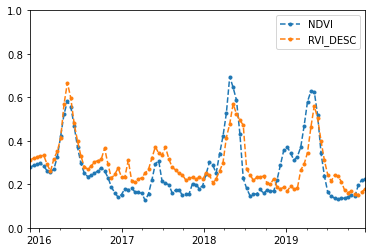

In [13]:
plot = df_mogpr_out_mean.plot(marker='.', linestyle='--')
fig = plot.get_figure()
ax = fig.gca()
ax.set_ylim([0, 1])